## Log-playback (expert) trajectory extraction and usage

This notebook demonstrates how to extract expert actions using different dynamics models and step through scene with those actions. 

Details on the dynamics models are found in [the docs](https://github.com/Emerge-Lab/gpudrive/tree/main/pygpudrive/env).

See also the [`LogTrajectory`](https://github.com/Emerge-Lab/gpudrive/blob/main/pygpudrive/datatypes/trajectory.py) datatype and [usage](https://github.com/Emerge-Lab/gpudrive/blob/c2ebb838a6b684c0f579c149bcb74f9cf31dc3ba/pygpudrive/env/env_torch.py#L436).

In [1]:
from gpudrive.env.dataset import SceneDataLoader
from gpudrive.visualize.utils import img_from_fig
from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.env.config import EnvConfig, SceneConfig
import os
from pathlib import Path
import mediapy

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while not 'gpudrive' in working_dir.name:
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

### Configurations

In [ ]:
DYNAMICS_MODEL = "delta_local"  # "delta_local" / "state" / "classic"
DATA_PATH = "data/exp/"  # Your data path
MAX_NUM_OBJECTS = 64
NUM_ENVS = 1

# Configs
env_config = EnvConfig(dynamics_model=DYNAMICS_MODEL)

### Make environment

In [4]:
# Make dataloader
data_loader = SceneDataLoader(
    root="data/exp",  # Path to the dataset
    # Batch size, you want this to be equal to the number of worlds (envs) so that every world receives a different scene
    batch_size=NUM_ENVS,
    dataset_size=NUM_ENVS,  # Total number of different scenes we want to use
    sample_with_replacement=False,
    seed=42,
    shuffle=True,
)

# Make environment
env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=data_loader,
    # Maximum number of agents to control per scenario
    max_cont_agents=MAX_NUM_OBJECTS,
    device="cpu",
    action_type="continuous"  # "continuous" or "discrete"
)

### Get log-playback (expert) actions

- Different dynamics models have different action spaces. For details, [see the docs.](https://github.com/Emerge-Lab/gpudrive/tree/main/pygpudrive/env)

In [5]:
control_mask = env.cont_agent_mask

obs = env.reset(control_mask)

In [6]:
# Extract full expert trajectory
expert_actions, _, _, _ = env.get_expert_actions()

expert_actions.shape  # Shape: (num_envs, num_steps, num_agents, num_actions)

torch.Size([1, 64, 91, 3])

### Step through an episode

In [7]:
# Reset environment
obs = env.reset(control_mask)
done_envs = []

frames = {f"env_{i}": [] for i in range(NUM_ENVS)}

# Step through the scene
for t in range(env.episode_len):

    env.step_dynamics(expert_actions[:, :, t, :])

    dones = env.get_dones()

    # Render the scenes
    env_indices = [i for i in range(NUM_ENVS) if i not in done_envs]
    figs = env.vis.plot_simulator_state(
        env_indices=env_indices,
        time_steps=[t]*NUM_ENVS,
        zoom_radius=100,
        # center_agent_indices=[0]*NUM_ENVS,
    )
    for i, env_id in enumerate(env_indices):
        frames[f"env_{env_id}"].append(img_from_fig(figs[i]))

    # Check if done
    for env_id in range(NUM_ENVS):
        if dones[env_id].all():
            done_envs.append(env_id)

## Show videos

env_0

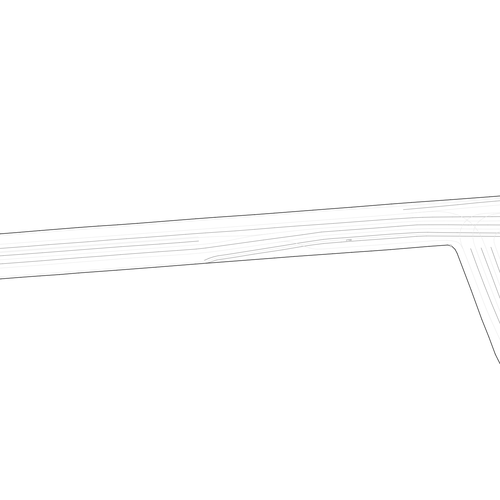

In [8]:
mediapy.show_videos(frames, fps=15, columns=3, codec='gif', width=500)